In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cmdstanpy
import arviz as av
import seaborn as sns
import pickle
np.random.seed(1)

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['figure.figsize'] = (11, 7)

Define a function to read in the appropriate data set and do some preprocessing.

In [2]:
def import_data(dataset):
    # for globular cluster data set
    if dataset == 'gc': 
        d = pd.read_csv('../data/GC_Vasiliev.csv', skipinitialspace=True)
        d.columns = d.columns.str.strip()
        d['Fullname'] = d['Fullname'].str.strip()
        d = d[~np.isnan(d.Vlos)] # make sure we have Vlos data
        d = d[d['Rgc'] > 15] # only use GCs outside 15kpc radius

    # for dwarf galaxy data set
    elif dataset == 'dg':
        d = pd.read_csv('../data/DG_Fritz.csv', skipinitialspace=True)
        d.columns = d.columns.str.strip()
        d['Fullname'] = d['Fullname'].str.strip()
        d = d[~np.isnan(d.Vlos)] # make sure we have Vlos data
        ignore_dg = ["Carina II", "Carina III", "Horologium I", "Hydrus I"] # ignore these DGs, they are possibly associated with the LMC
        d = d[~d['Fullname'].isin(ignore_dg)]
        d = d[d['Rgc'] > 15] # only use DGs outside 15kpc radius

    return d

In [51]:
d = import_data('gc') # or dg

Read in the Stan code from a file and compile it.

In [4]:
# load a saved model from last time...

# saved = pickle.load(open('../saved/gc_dg/eadie2019/a', 'rb'))
# fit = saved['fit']

In [54]:
# or compile a new model
    
sm = cmdstanpy.CmdStanModel(stan_file='../models/gc.stan')#, cpp_options={"STAN_THREADS": True, "STAN_OPENCL": True})

INFO:cmdstanpy:compiling stan program, exe file: /home/js/programs/gmestan/models/gc
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/js/programs/gmestan/models/gc


Format the data to be passed in to Stan.

In [61]:
standata = {
    'N': len(d),

    'ra': d.RA.to_numpy(),
    'dec': d.DEC.to_numpy(),
    'plx': d.plx.to_numpy(),
    
    'Xgc': d.Xgc.to_numpy(),
    'Ygc': d.Ygc.to_numpy(),
    'Zgc': d.Zgc.to_numpy(),
    
    'pmra_measured': d.PMra.to_numpy(),
    'pmdec_measured': d.PMdec.to_numpy(),
    'vlos_measured': d.Vlos.to_numpy(),
    'r_measured': d.Rgc.to_numpy(),
    
    'pmra_err': d.ePMra.to_numpy(),
    'pmdec_err': d.ePMdec.to_numpy(),
    'vlos_err': d.eVlos.to_numpy(),
    'r_err': d.eRgc.to_numpy(),

}

Define a function which generates a dictionary with the initial values. The type for each parameter must match what is defined in the Stan model. 

In [62]:
def init_gen():
    return {
        # for the GC data set, these values seem to work well
        
        'p_gamma': np.random.uniform(0.4, 0.55),
        'p_phi0': np.random.uniform(60, 80),
        'p_beta': np.random.uniform(-0.1, 0.5),
        'p_alpha': np.random.uniform(3.1, 3.5),
        
        # for the DG dataset, the (hyper)priors are different so 
        # use these (random) initial values instead
#         'p_beta': np.random.uniform(-2.5, 0.5),
#         'p_alpha': np.random.uniform(3.3, 3.7),
        
        'pmra': np.full(standata['N'], 1e-6),
        'pmdec': np.full(standata['N'], 1e-6),
        'vlos': np.ones(standata['N']),
        'r': np.random.uniform(0, max(standata['r_measured']), size=int(standata['N'])),
    }

Run the compiled Stan model, passing in at the minimum the data to use. Here we also specify the number of chains (where each chain is run on a separate thread), the initial values, and some additional parameters controlling the algorithm. 

`adapt_delta` effectively controls the step size of the numerical integrator. Run the code with lower values (default is 0.8) first, and if the number of divergences is significant enough to impact the validity of the samples then increase this value. This increases the model robustness but may lead to slower sampling. Do not increase this if you only have a few divergences out of a few thousand draws, or if your `n_eff` is already reasonably large.

`max_treedepth` increases the depth of the binary tree created for each NUTS iteration when the sampler integrates forward and backward in time. If the code complains about saturated tree depths, this value may need to be increased. This will increase the runtime. Note that saturated tree depths are an efficiency problem, not a validity problem. 

`chains` controls the number of Markov chains to use. The default is 4. Each chain runs on a separate core, and you can set the number of chains to as many cores as you have. However, since `n_eff` of a few hundred is usually enough for inference, more chains are not always necessary. Increasing the number of chains may also increase the runtime. Use `chains=1` for diagnostic purposes. 

`iter_warmup` controls the number of iterations to perform in the warmup stage. This helps NUTS find the optimal number of steps and the step size, and the samples drawn here are not used for inference purposes. `iter_sampling` controls the total number of sampling iterations to perform. 

In [68]:
fit = sm.sample(
    data = standata,
    inits = init_gen(),
    adapt_delta=0.9,
    chains = 2,
    show_progress = 'notebook',
    output_dir='../saved/gc_dg/eadie2019/'
)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Check that things look okay with `diagnose`.

In [69]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /home/js/programs/gmestan/saved/gc_dg/eadie2019/gc-202106171514-1.csv, /home/js/programs/gmestan/saved/gc_dg/eadie2019/gc-202106171514-2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
9 of 2000 (0.45%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


Processing csv files: /home/js/programs/gmestan/saved/gc_dg/eadie2019/gc-202106171514-1.csv, /home/js/programs/gmestan/saved/gc_dg/eadie2019/gc-202106171514-2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
9 of 2000 (0.45%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


These are the parameters of most interest. 

In [70]:
params = ["p_phi0", "p_gamma", "p_beta", "p_alpha"]

Make sure that divergences (if any) are not problematic. 

<AxesSubplot:>

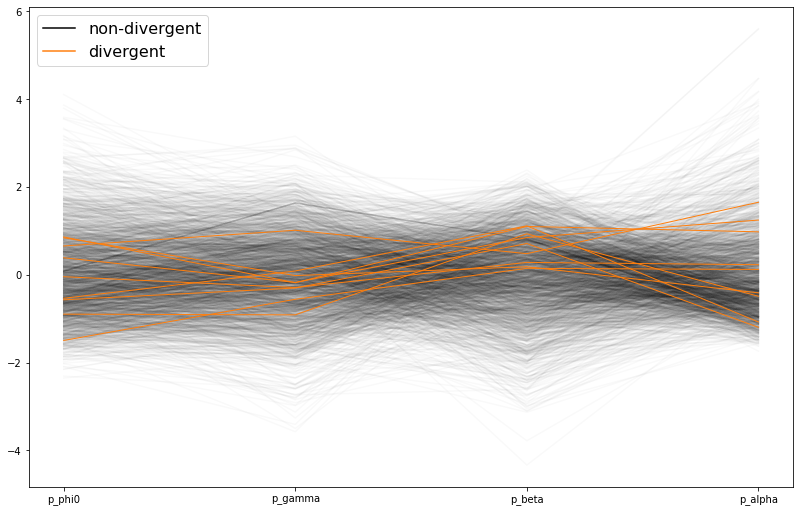

In [72]:
av.plot_parallel(fit, var_names=params, norm_method='normal')

Plot a pairs plot for the parameters of interest.

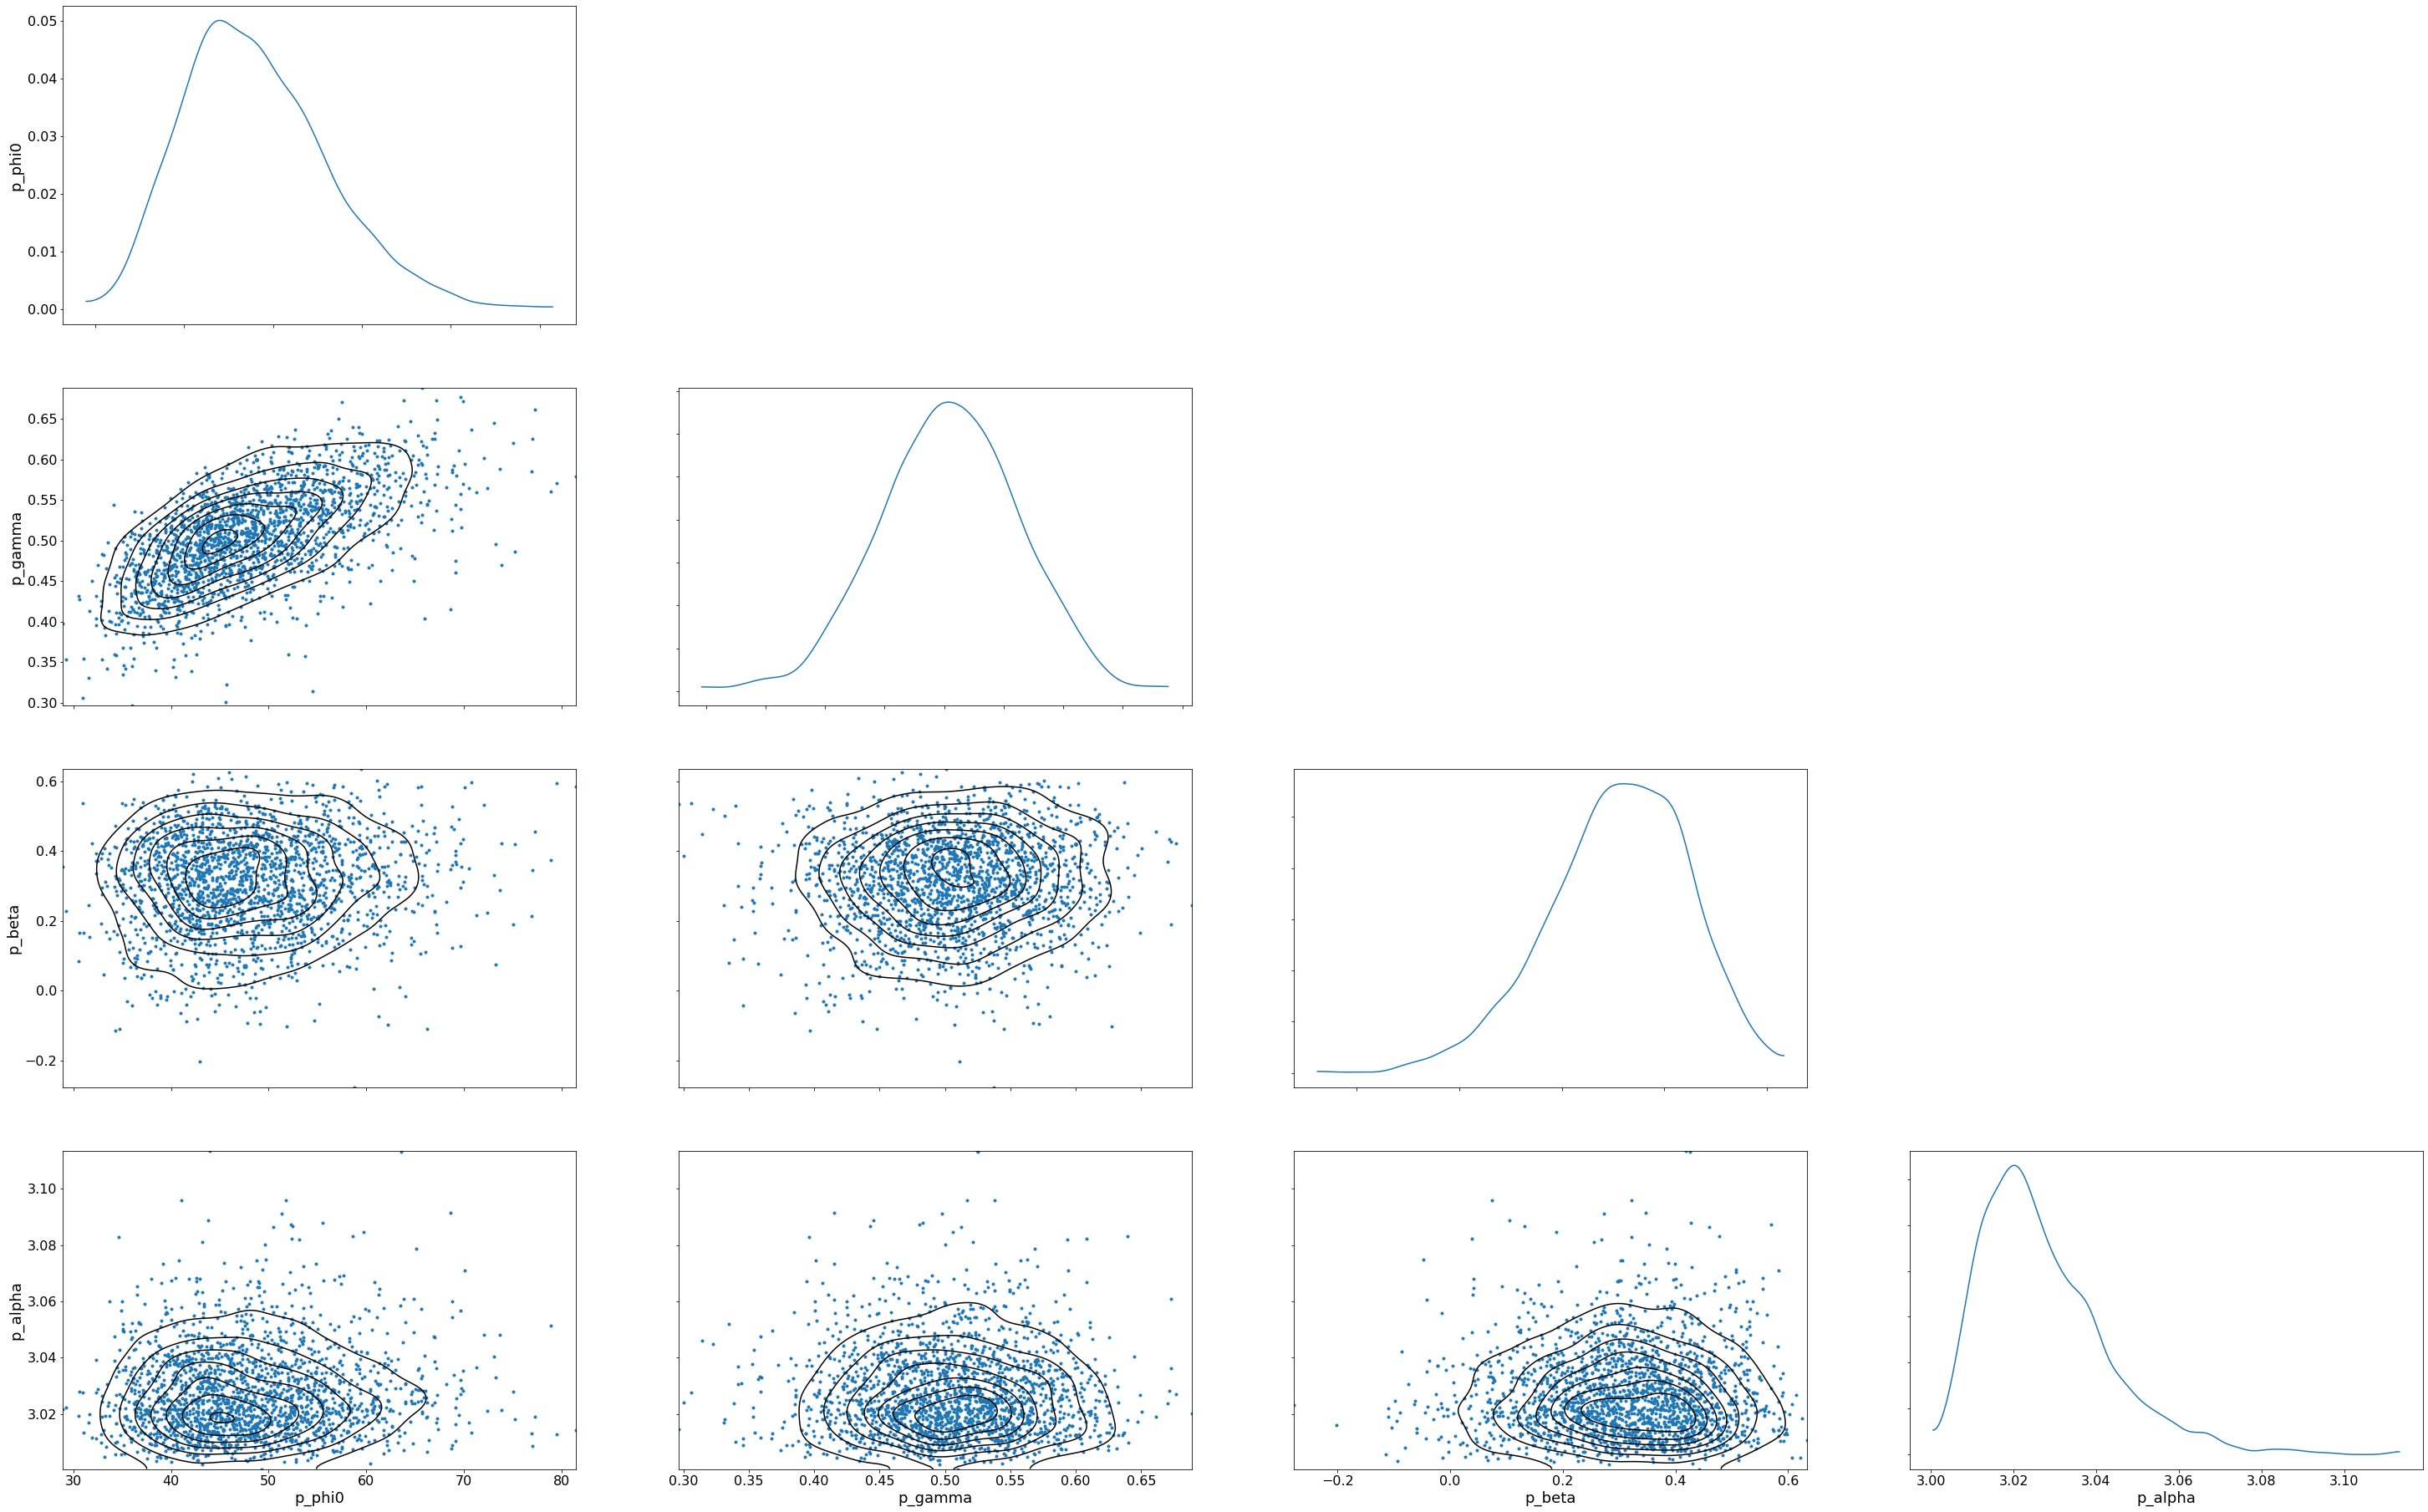

In [73]:
ax = av.plot_pair(fit, var_names=params, kind=['kde', 'scatter'], marginals=True);

In the first column, plot the densities for each of the parameters of interest. These are separated by chains, and the density plots across chains should look relatively similar.

In the second column, plot traceplots for each of the parameters of interest. These are like usual traceplots, and should look like Gaussian noise with a stable means and (positive) variances. 

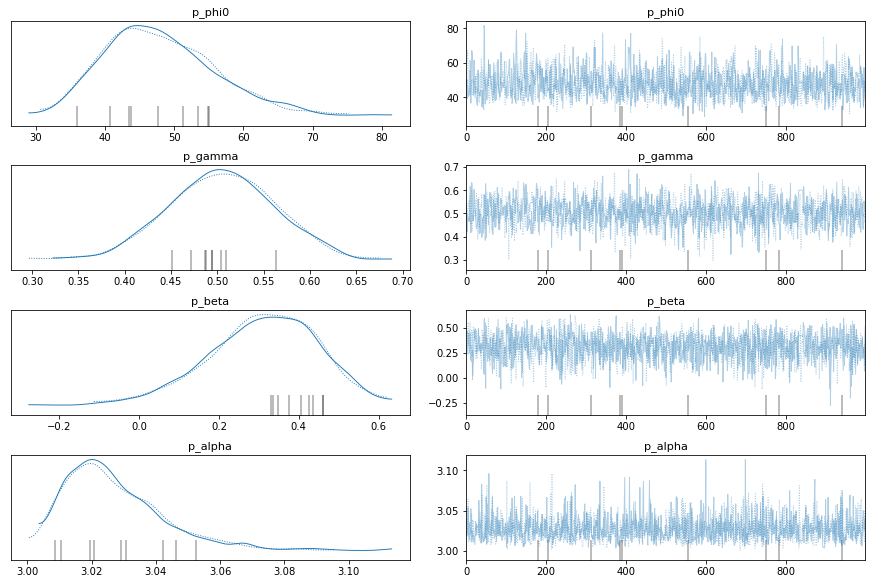

In [84]:
av.plot_trace(fit, var_names=params);

Extract posterior draws from the model.

In [79]:
la = fit.stan_variables()

Define a function which, given the radius in kpc and some posterior draws, returns either a large number of mass estimates at that radius, or some summary statistics for the mass at that radius. The resulting mass is in units of $10^{12}$ M$_\odot$.

In [142]:
def mass_at_radius(r, samples, full=False):
    masses = samples['p_phi0'] * samples['p_gamma'] * 2.325e-3 * r**(1 - samples['p_gamma'])
    if full: 
        return masses
    return np.quantile(masses, [0.025, 0.125, 0.25, 0.5, 0.75, 0.875, 0.975]) # quantiles that we want to get

Plot the mass distribution out to 250 kpc, along with various credible intervals.

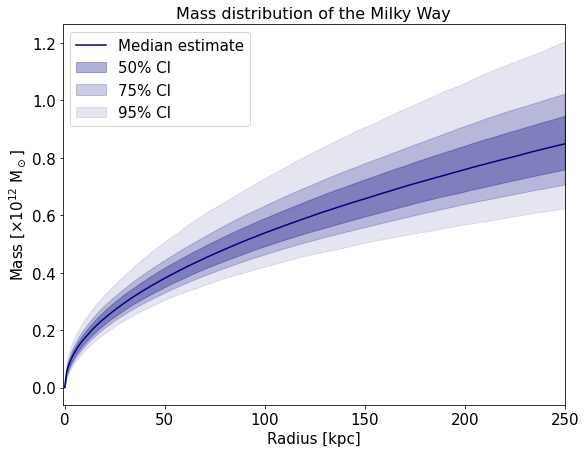

In [157]:
plt.figure(figsize=(9, 7))
radii = np.arange(251) # up to 250 kpc
masses = np.zeros((len(radii), 7))

for r in radii:
    masses[r] = mass_at_radius(r, la) # 251 x 7 array of various quantiles of masses at different radii
    
plt.plot(radii, masses[:, 3], c='navy', label='Median estimate')
plt.fill_between(radii, masses[:, 2], masses[:, 4], alpha=0.3, color='navy', label='50% CI')
plt.fill_between(radii, masses[:, 1], masses[:, 5], alpha=0.2, color='navy', label='75% CI')
plt.fill_between(radii, masses[:, 0], masses[:, 6], alpha=0.1, color='navy', label='95% CI')

plt.legend(loc='upper left', fontsize=15)
plt.title('Mass distribution of the Milky Way', fontsize=16)
plt.xlabel('Radius [kpc]', fontsize=15)
plt.ylabel(r'Mass [$\times 10^{12}$ M$_\odot$]', fontsize=15)
plt.xlim(-1, 250)
plt.xticks(size=15)
plt.yticks(size=15);

Calculate the virial radius $r_{200}$ and plot the density of the mass $M_{200}$ within it (essentially a vertical slice of the plot above).

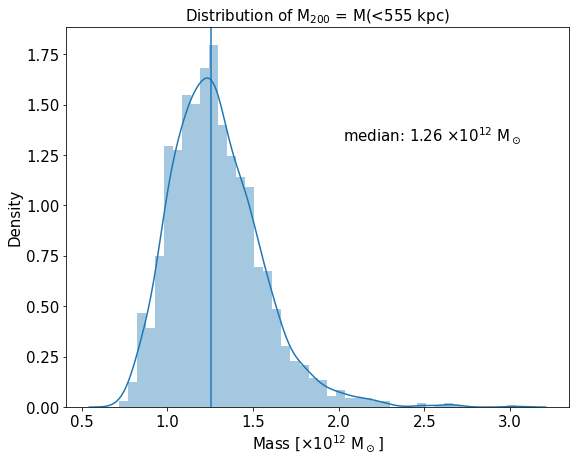

In [127]:
def calc_rvir(gamma, phi0, H=0.678e-3):
    return (gamma * phi0 / (100 * H**2)) ** (1 / 2 + gamma)

rvir = calc_rvir(
    np.median(la['p_gamma']), 
    np.median(la['p_phi0'])
) / 1000 # convert to kpc

plt.figure(figsize=(9, 7))

virial_mass = mass_at_radius(rvir, la, full=True)

sns.distplot(virial_mass) # density 
plt.axvline(np.median(virial_mass)) # draw a vertical line at the median mass
plt.annotate(rf"median: {np.median(virial_mass):.2f} $\times 10^{{12}}$ M$_\odot$", xy=(0.55, 0.7), xycoords='axes fraction', fontsize=15)

plt.title(rf'Distribution of M$_{{{200}}}$ = M(<{rvir:.0f} kpc)', fontsize=15)
plt.xlabel(r'Mass [$\times 10^{12}$ M$_\odot$]', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(size=15)
plt.yticks(size=15);

In [83]:
# save model 
with open("../saved/gc_dg/eadie2019/gc.pkl", "wb") as f:
    pickle.dump({'fit' : fit}, f, protocol=-1)